# Week 5: Linear Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy import stats
from sklearn import linear_model


%matplotlib inline

Recall from last week:

In [2]:
qm7b = pd.read_csv('http://faculty.washington.edu/tingcao/wordpress/wp-content/uploads/2020/10/qm7b.csv');
qm7b.head()

,id,ae_pbe0,emax_zindo,imax_zindo,homo_zindo,lumo_zindo,e1_zindo,ip_zindo,ea_zindo,homo_pbe0,...,homo_gw,lumo_gw,p_pbe0,p_scs,n_H,n_C,n_N,n_O,n_S,n_Cl
0,1,-420.933746,39.694626,0.621841,-16.013,4.162,36.768073,15.72523,-3.98613,-10.9488,...,-14.1341,1.0870,2.534576,2.43222,4,1,0,0,0,0
1,2,-718.419189,22.622486,0.628328,-13.549,3.684,11.717433,13.41121,-3.49181,-9.5577,...,-12.5472,1.1186,4.332028,4.44500,6,2,0,0,0,0
2,3,-570.024841,22.940671,0.709060,-10.160,1.231,7.137266,9.75211,-0.82042,-7.8768,...,-10.4383,1.9456,4.173282,3.92308,4,2,0,0,0,0
3,4,-410.286163,15.973798,2.228480,-10.706,2.145,4.624107,10.46577,-1.89847,-8.4021,...,-11.1629,1.1958,3.512394,3.32175,2,2,0,0,0,0
4,5,-868.855408,17.900516,0.556174,-12.365,3.825,10.311655,11.96491,-3.57487,-8.3534,...,-10.8132,1.2002,5.480160,5.78632,6,3,0,0,0,0


In [3]:
qm7b.keys()

Index(['id', 'ae_pbe0', 'emax_zindo', 'imax_zindo', 'homo_zindo', 'lumo_zindo',
       'e1_zindo', 'ip_zindo', 'ea_zindo', 'homo_pbe0', 'lumo_pbe0', 'homo_gw',
       'lumo_gw', 'p_pbe0', 'p_scs', 'n_H', 'n_C', 'n_N', 'n_O', 'n_S',
       'n_Cl'],
      dtype='object')

| Column Name | Unit  |  Description |
|----------|----------|-----------|
|ae_pbe0   |kcal/mol  |Atomization energy (DFT/PBE0)
|p_pbe0    |Angstrom^3|Polarizability (DFT/PBE0)
|p_scs     |Angstrom^3|Polarizability (self-consistent screening)
|homo_gw   |eV        |Highest occupied molecular orbital (GW)
|homo_pbe0 |eV        |Highest occupied molecular orbital (DFT/PBE0)
|homo_zindo|eV        |Highest occupied molecular orbital (ZINDO/s)
|lumo_gw   |eV        |Lowest unoccupied molecular orbital (GW)
|lumo_pbe0 |eV        |Lowest unoccupied molecular orbital (DFT/PBE0)
|lumo_zindo|eV        |Lowest unoccupied molecular orbital (ZINDO/s)
|ip_zindo  |eV        |Ionization potential (ZINDO/s)
|ea_zindo  |eV        |Electron affinity (ZINDO/s)
|e1_zindo  |eV        |First excitation energy (ZINDO)
|emax_zindo|eV        |Maximal absorption intensity (ZINDO)
|imax_zindo|arbitrary |Excitation energy at maximal absorption (ZINDO)
|n_H       |          |number of Hydrogen atoms
|n_C       |          |number of Carbon atoms
|n_N       |          |number of Nitrogen atoms
|n_O       |          |number of Oxygen atoms
|n_S       |          |number of Sulfur atoms
|n_Cl      |          |number of Chlorine atoms

In [4]:
qm7b.shape

(7211, 21)

## Introduction

We will be using the 5-step recipe outlined by Prof.Cao for performing regression fittings. The five steps are as follows:

1. Select a class of model (e.g.`from sklearn import linear_model`)
2. Specify model hyperparameters
3. Organize data into a Features matrix and target array
3. Fit the model to the training data (`.fit`)
4. Use the model to make predictions for new data (`.predict()` for supervised learning, and `.transform()` or `.predict()` for unsupervised learning)

In [5]:
from IPython.display import Image
Image(url = 'https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.02-samples-features.png')

Note that the *Features matrix* is often stored as a variable X (by convention). It is 2-dimensional, with shape `[n_samples,n_features]`, and often taken as a NumPy array or Pandas `DataFrame`. Note that each row represents a sample whereas each column represents a feature/parameter expressable quantitatively, such as a number, a sound file, a document, an image, etc. 

The *Target array*, often `y` by convention, is 1-dimensional with length `n_samples` and is often a NumPy array or Pandas `series`.

## Feature Correlation

Let's first plot a feature correlation diagram, using the `seaborn` package introduced 2 weeks ago.

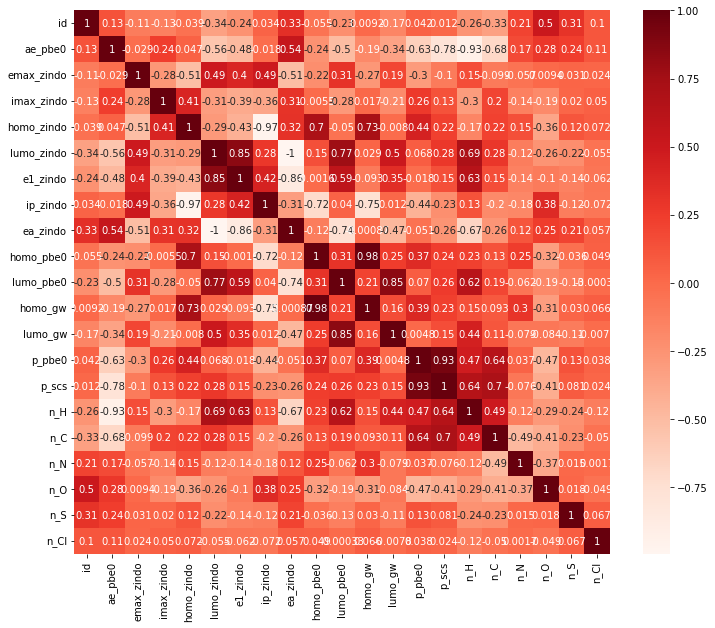

In [6]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = qm7b.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

The Correlation Coefficient is calculated as follows with the **Pearson Correlation Formula**:

$r=\frac{n(\sum xy)-(\sum x)(\sum y)}{\sqrt{(n\sum{x^2}-(\sum x)^2)(n\sum y^2-(\sum y)^2}}$

Where:
- x represents each value in the x dataset
- y represents each value in the y dataset, and 
- n is the number of elements in each set

Where a **Correlation Coefficient** of:
- 1 indicates strong positive correlation,
- -1 indicates strong negative correlation, and
- 0 implies no correlation.
The Coefficient can take on a range of values between -1 and 1.

This diagram allows us to quickly determine the level of correlation between each of the columns of the `qm7b` dataframe. Notice that the diagonal is all solid 1's because every feature is perfectly correlated with itself.

$R^2$ values will be explained later in this notebook and can also be used as a metric for the level of correlation between two sets of data - in this context it is known as a **Coefficient of Determination**

## Simple Linear Regression

Here we perform a fitting of the form:

### $y=\beta_0+\beta_1x_1$
where:
- $\beta_0$ is the intercept and 
- $\beta_1$ is the slope or coefficient

Let's try perform a simple linear regression fitting of `homo_pbe0` and `homo_gw`!

In [7]:
#Step 1
#from sklearn import linear_model 
#we already imported this at the beginning of this notebook

In [8]:
#Step 2 
model1 = linear_model.LinearRegression()

In [9]:
#Step 3 (Remember to use DOUBLE square brackets to make the Features matrix 2-dimensional!!)
#what not to do:
x1 = qm7b['homo_pbe0']
x1.shape

(7211,)

In [10]:
type(x1)

pandas.core.series.Series

In [11]:
#what TO do:
X1 = qm7b[['homo_pbe0']]
X1.shape

(7211, 1)

In [12]:
type(X1)

pandas.core.frame.DataFrame

In [13]:
y1 = qm7b['homo_gw']
y1.shape

(7211,)

In [14]:
#Step 4
model1.fit(X1.values,y1.values)

LinearRegression()

In [15]:
model1.coef_ #beta_1

array([1.08558281])

In [16]:
model1.intercept_ #beta_0

-1.47839531165054

In [17]:
#Step 5
xfit = np.linspace(-11,-4)
Xfit = xfit[:, np.newaxis] #this changes xfit from a horizontal array to a vertical array!
yfit = model1.predict(Xfit)

In [18]:
xfit

array([-11.        , -10.85714286, -10.71428571, -10.57142857,
       -10.42857143, -10.28571429, -10.14285714, -10.        ,
        -9.85714286,  -9.71428571,  -9.57142857,  -9.42857143,
        -9.28571429,  -9.14285714,  -9.        ,  -8.85714286,
        -8.71428571,  -8.57142857,  -8.42857143,  -8.28571429,
        -8.14285714,  -8.        ,  -7.85714286,  -7.71428571,
        -7.57142857,  -7.42857143,  -7.28571429,  -7.14285714,
        -7.        ,  -6.85714286,  -6.71428571,  -6.57142857,
        -6.42857143,  -6.28571429,  -6.14285714,  -6.        ,
        -5.85714286,  -5.71428571,  -5.57142857,  -5.42857143,
        -5.28571429,  -5.14285714,  -5.        ,  -4.85714286,
        -4.71428571,  -4.57142857,  -4.42857143,  -4.28571429,
        -4.14285714,  -4.        ])

In [19]:
Xfit

array([[-11.        ],
       [-10.85714286],
       [-10.71428571],
       [-10.57142857],
       [-10.42857143],
       [-10.28571429],
       [-10.14285714],
       [-10.        ],
       [ -9.85714286],
       [ -9.71428571],
       [ -9.57142857],
       [ -9.42857143],
       [ -9.28571429],
       [ -9.14285714],
       [ -9.        ],
       [ -8.85714286],
       [ -8.71428571],
       [ -8.57142857],
       [ -8.42857143],
       [ -8.28571429],
       [ -8.14285714],
       [ -8.        ],
       [ -7.85714286],
       [ -7.71428571],
       [ -7.57142857],
       [ -7.42857143],
       [ -7.28571429],
       [ -7.14285714],
       [ -7.        ],
       [ -6.85714286],
       [ -6.71428571],
       [ -6.57142857],
       [ -6.42857143],
       [ -6.28571429],
       [ -6.14285714],
       [ -6.        ],
       [ -5.85714286],
       [ -5.71428571],
       [ -5.57142857],
       [ -5.42857143],
       [ -5.28571429],
       [ -5.14285714],
       [ -5.        ],
       [ -4

Text(0.5, 0, 'homo_pbe0 (eV)')

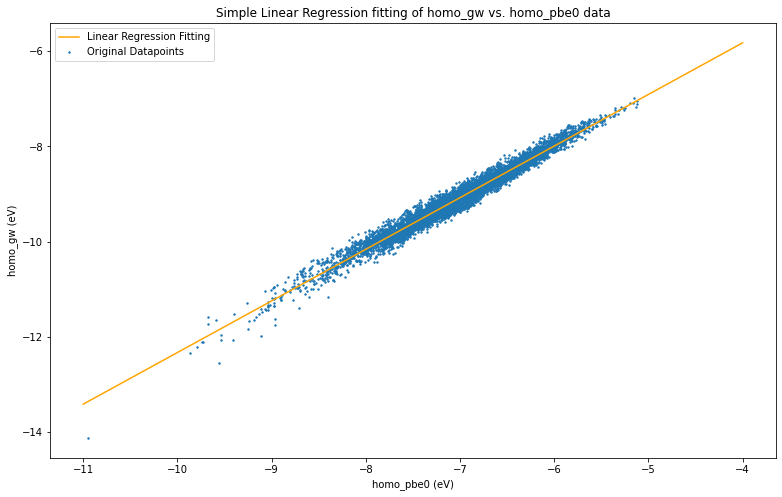

In [20]:
plt.figure(figsize = (13,8))
plt.scatter(x1, y1, s=2, label='Original Datapoints')
plt.plot(xfit, yfit, c='orange', label='Linear Regression Fitting');
plt.legend()
plt.title('Simple Linear Regression fitting of homo_gw vs. homo_pbe0 data')
plt.ylabel('homo_gw (eV)')
plt.xlabel('homo_pbe0 (eV)')

#### Exercise 1: Perform a Simple Linear Regression fitting of `lumo_pbe0` to `lumo_gw` from scratch

In [21]:
model_lumo_pbe0_gw = linear_model.LinearRegression()

In [22]:
x_lumo_pb0_ori = qm7b['lumo_pbe0']
x_lumo_pb0_ori.shape

(7211,)

In [23]:
X_lumo_pb0_ori = qm7b[['lumo_pbe0']]
X_lumo_pb0_ori.shape

(7211, 1)

In [24]:
X_lumo_pb0_ori.describe()

,lumo_pbe0
count,7211.000000
mean,-0.515284
std,0.681024
min,-3.805600
25%,-0.819300
50%,-0.221600
75%,-0.047350
max,0.414300


In [25]:
y_lumo_gw = qm7b['lumo_gw']
y_lumo_gw.shape

(7211,)

In [26]:
model_lumo_pbe0_gw.fit(X_lumo_pb0_ori.values,y_lumo_gw.values)

LinearRegression()

In [27]:
x_lumo_pb0_fit = np.linspace(-4,1)
X_lumo_pb0_fit = x_lumo_pb0_fit[:, np.newaxis] #this changes xfit from a horizontal array to a vertical array!
Y_lumo_gw_fit = model_lumo_pbe0_gw.predict(X_lumo_pb0_fit)

Text(0.5, 0, 'lumo_pbe0 (eV)')

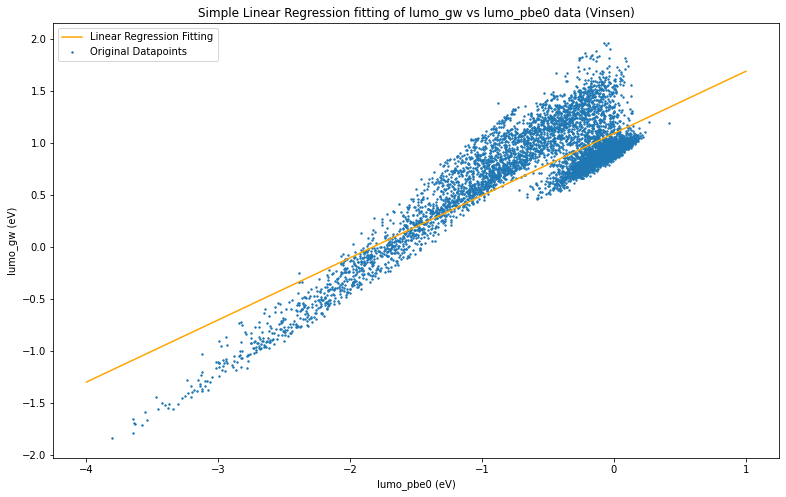

In [75]:
plt.figure(figsize = (13,8))
plt.scatter(x_lumo_pb0_ori, y_lumo_gw, s=2, label='Original Datapoints')
plt.plot(x_lumo_pb0_fit,Y_lumo_gw_fit, c='orange', label='Linear Regression Fitting');
plt.legend()
plt.title('Simple Linear Regression fitting of lumo_gw vs lumo_pbe0 data (Vinsen)')
plt.ylabel('lumo_gw (eV)')
plt.xlabel('lumo_pbe0 (eV)')

### Multiple Linear Regression

Let's now tackle multidimensional linear models also using the `LinearRegression` estimator. The fitting will take on the following form:


$y = \beta_0 +\begin{pmatrix}
\beta_1\\
\beta_2\\
...\\
\beta_n\\
\end{pmatrix} $ $\centerdot \begin{pmatrix}
x_1\\
x_2\\
...\\
x_n\\
\end{pmatrix} $

In other words:

$y=\beta_0+\beta_1x_1+\beta_2x_2+⋯$

Where:
- each $x_n$ value represents a different feature and 
- each $\beta_n$ value represents the corresponding coefficient for feature $x_n$ in the fitting.

The geometric analog to this would be fitting a plane to points in 3-dimensional space, or fitting a hyperplane to points in higher-dimensional space.

Let's try to predict the first excitation energies `e1_zindo` from our `homo_zindo` and `lumo_zindo` values! Let's see if `e1_zindo` can be accurately approximated by a linear combination of `homo_zindo` and `lumo_zindo` values.

Firstly, let's observe how this looks in real space:

Text(0.5, 0.92, 'First Excitation Energy vs HOMO and LUMO in Zindo Simulations')

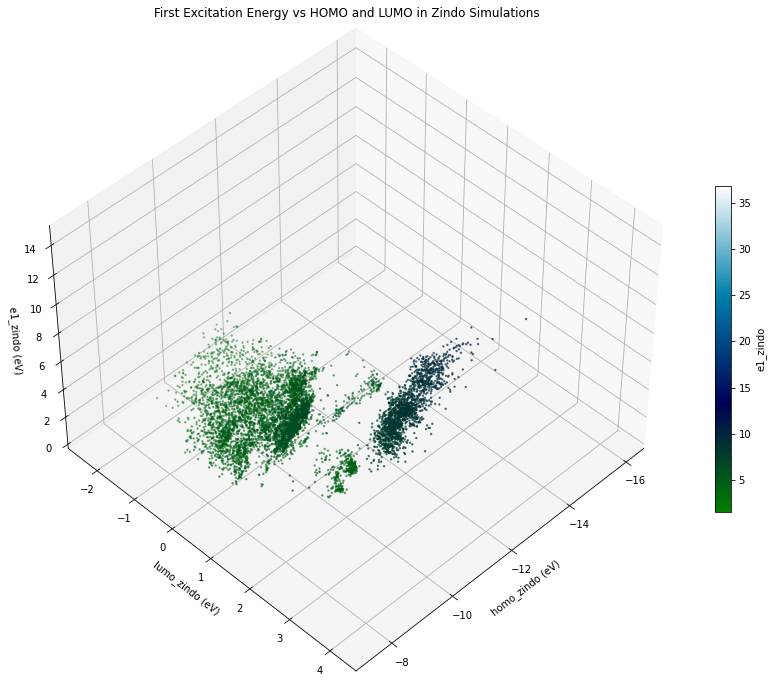

In [29]:
plt.figure(figsize=(15,12))
ax = plt.axes(projection = '3d',zlim = [0,15])
plot1=ax.scatter3D(qm7b['homo_zindo'], qm7b['lumo_zindo'], qm7b['e1_zindo'], s=2, c=qm7b['e1_zindo'], cmap='ocean')
cbar=plt.colorbar(plot1, shrink=0.5)
cbar.set_label('e1_zindo')
#Feel free to play around with the values in ax.view_init(), 
#which allows you to change the viewing angle of your final plot
ax.view_init(45,45)
ax.set_xlabel('homo_zindo (eV)')
ax.set_ylabel('lumo_zindo (eV)')
ax.set_zlabel('e1_zindo (eV)')
ax.set_title('First Excitation Energy vs HOMO and LUMO in Zindo Simulations')

In [30]:
#Step 1
#from sklearn import linear_model 
#we already imported this at the beginning of this notebook

In [31]:
#Step 2 
model2 = linear_model.LinearRegression()

In [32]:
#Step 3
X2 = qm7b[['homo_zindo','lumo_zindo']]
X2.shape

(7211, 2)

In [33]:
y2 = qm7b['e1_zindo']
y2.shape

(7211,)

In [34]:
#Step 4
model2.fit(X2,y2)

LinearRegression()

In [35]:
model2.intercept_

0.4695946676895666

The following coefficients represent the 'slopes' or 'weights' of each of the 2 features in the features matrix:

In [36]:
model2.coef_

array([-0.4013178 ,  1.12471506])

Text(0.5, 0.92, 'Regression Fitting of First Excitation Energies vs HOMO and LUMO in Zindo Simulations')

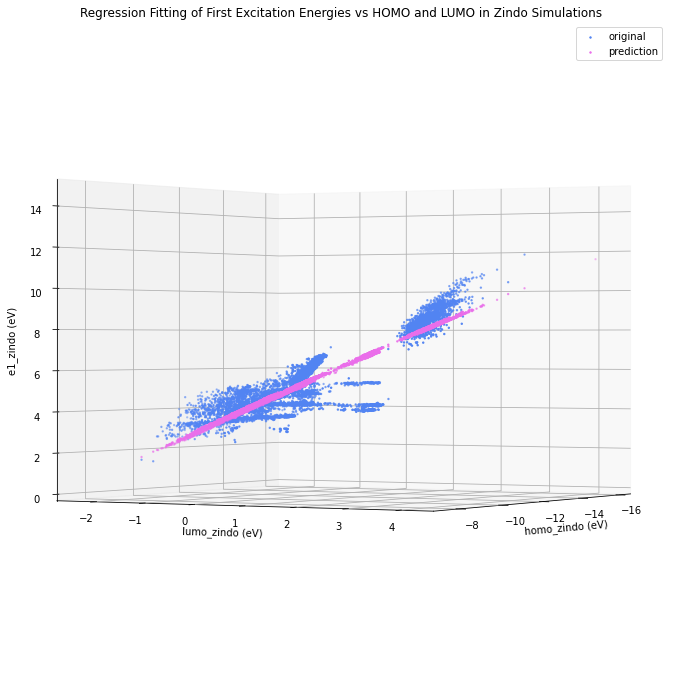

In [37]:
#Step 5
plt.figure(figsize=(15,12))
ax = plt.axes(projection = '3d')
ax = plt.axes(projection='3d')
plot1=ax.scatter3D(qm7b['homo_zindo'], qm7b['lumo_zindo'], qm7b['e1_zindo'], s=2, 
                   c='#5284F2', label='original')
plot2=ax.scatter3D(qm7b['homo_zindo'], qm7b['lumo_zindo'],
                   model2.predict(qm7b[['homo_zindo','lumo_zindo']]), c='#EA6EEA', s=2, 
                   label='prediction')
#as always, play around with these angles to explore the fitted plane/surface
ax.view_init(0,30)
ax.set_xlabel('homo_zindo (eV)')
ax.set_ylabel('lumo_zindo (eV)')
ax.set_zlabel('e1_zindo (eV)')
ax.set_zlim(0,15)
ax.legend()
ax.set_title('Regression Fitting of First Excitation Energies vs HOMO and LUMO in Zindo Simulations')

#### Exercise 2: Perform a 3D fitting of `lumo_gw` and `lumo_pbe0` data to `lumo_zindo`, where the feature matrix consists of `lumo_gw` and `lumo_pbe0`, and the target vector is `lumo_zindo`. Plot the original datapoints and your fitting on the same set of 3D axes.

In [38]:
model_lumo_gw_pbe0_zindo = linear_model.LinearRegression()

In [39]:
X_lumo_gw_pbe0 = qm7b[['lumo_gw','lumo_pbe0']]
X2.shape

(7211, 2)

In [40]:
X_lumo_gw_pbe0.describe()

,lumo_gw,lumo_pbe0
count,7211.000000,7211.000000
mean,0.783565,-0.515284
std,0.478699,0.681024
min,-1.837600,-3.805600
25%,0.730300,-0.819300
50%,0.887200,-0.221600
75%,0.989700,-0.047350
max,1.962400,0.414300


In [41]:
y_lumo_zindo = qm7b['lumo_zindo']
y_lumo_zindo.shape

(7211,)

In [42]:
model_lumo_gw_pbe0_zindo.fit(X_lumo_gw_pbe0,y_lumo_zindo)

LinearRegression()

In [43]:
model_lumo_gw_pbe0_zindo.coef_

array([-1.52045969,  2.39295136])

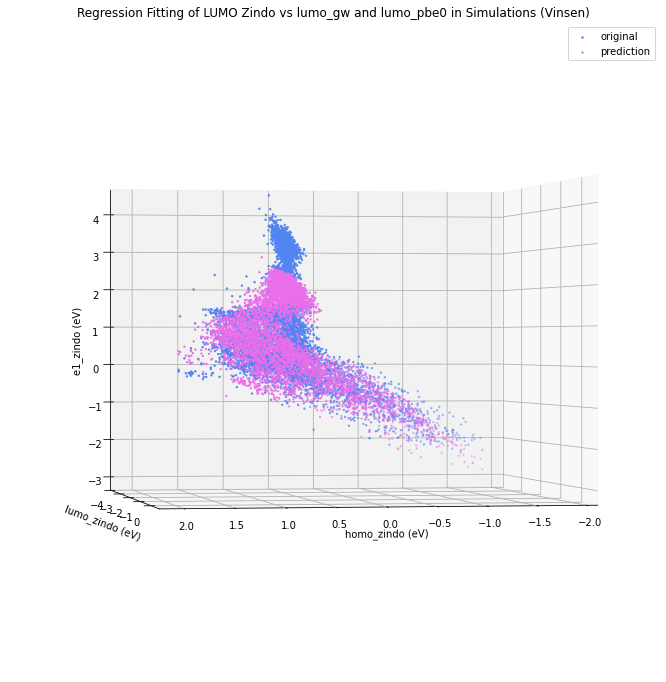

In [76]:
#Step 5 (try to use linspace to fit, be careful with the length) 
plt.figure(figsize=(15,12))
ax = plt.axes(projection = '3d')
ax = plt.axes(projection='3d')
plot1=ax.scatter3D(qm7b['lumo_gw'], qm7b['lumo_pbe0'], qm7b['lumo_zindo'], s=2, 
                   c='#5284F2', label='original')
plot2=ax.scatter3D(qm7b['lumo_gw'], qm7b['lumo_pbe0'],
                   model_lumo_gw_pbe0_zindo.predict(qm7b[['lumo_gw','lumo_pbe0']]), c='#EA6EEA', s=1.7,
                   label='prediction')
#as always, play around with these angles to explore the fitted plane/surface
ax.view_init(0,80)
ax.set_xlabel('homo_zindo (eV)')
ax.set_ylabel('lumo_zindo (eV)')
ax.set_zlabel('e1_zindo (eV)')
#ax.set_zlim(0,15)
ax.legend()
ax.set_title('Regression Fitting of LUMO Zindo vs lumo_gw and lumo_pbe0 in Simulations (Vinsen)')
plt.show()

## Regression Metrics

Various regression metrics allow us to quantify the effectiveness of our regression fittings. 

### Least Squares

In [45]:
Image(url='https://mathworld.wolfram.com/images/eps-gif/LeastSquaresOffsets_1000.gif')

Let's also examine the least squares for each of the fittings we generate, to ensure that least squares are truly minimized. Here we're taking vertical offsets, that is to say the vertical difference between our fitting and the actual values, squared. Least squares are calculated as follows:

The difference between the model's prediction and the observed value is otherwise known in statistics as a **residual**. Least squares are thus a sum of the squares of the residuals.

### $\Sigma_{n=1}^{N} (y_n - f(x_n))^2 $

Where:
- $y_n$ is each $y$ value in the Target Vector and
- $f(x_n)$ values are the model's predictions for the associated $x_n$ values

Thus, for the regression fitting above:

In [46]:
np.sum((y2-(model2.intercept_+model2.coef_[0]*qm7b['homo_zindo']+model2.coef_[1]*qm7b['lumo_zindo']))**2)

6101.311812224888

Recall:
    

In [47]:
model2.intercept_

0.4695946676895666

In [48]:
model2.coef_

array([-0.4013178 ,  1.12471506])

And for model 1:

In [49]:
model1.intercept_

-1.47839531165054

In [50]:
model1.coef_

array([1.08558281])

To ensure we have in fact **minimized** the Least Squares, play around with these values and observe that it does not go below the value printed above:

In [51]:
np.sum((y1-(-1.4783953116505426+1.08558281*qm7b['homo_pbe0']))**2)

116.04008581697084

In [52]:
np.sum((y1-(model1.intercept_+model1.coef_*qm7b['homo_pbe0']))**2)

116.04008581696884

### $R^2$ and 'Unexplained Variance'

The $R^2$ value is another way to determine the goodness of a fit. An $R^2$ value of 1 indicates that the model fits the data perfectly. An $R^2$ value of 0 indicates that none of the variation in the data is accounted for by the model. The actual $R^2$ value obtained can be anywhere between 0 and 1. 

#### $R^2 = 1-\frac{\Sigma_{n=1}^{N} (y_n - f(x_n))^2}{\Sigma_{n=1}^{N} (y_n - \bar{y})^2}$

Note that the denominator of the fraction is similar to the *variance* of all $y$ values (save for a factor of $(n-1)$, and the numerator is the least squares calculated above.
- $y_n$ is each y value in the Target Vector
- $\bar{y}$ is the average of the $y_n$ values
- $f(x_n)$ is the fitting model's prediction for the y values


$R^2$ for `model1`:

In [53]:
r_squared1 = 1-np.sum((y1-(model1.intercept_+model1.coef_*qm7b['homo_pbe0']))**2)/(np.var(y1)*(len(y1)))
r_squared1

0.9667659821332824

$R^2$ for `model2`:

In [54]:
r_squared2 = 1-np.sum((y2-(model2.intercept_+model2.coef_[0]*qm7b['homo_zindo']+model2.coef_[1]*qm7b['lumo_zindo']))**2)/(np.var(y2)*(len(y2)))
r_squared2

0.7567695867840217

Using an inbuilt `Scikit learn` function:

In [55]:
from sklearn.metrics import r2_score
r2_score(y1, model1.intercept_+model1.coef_*qm7b['homo_pbe0'])

0.9667659821332824

In [56]:
r2_score(y2, model2.intercept_+model2.coef_[0]*qm7b['homo_zindo']+model2.coef_[1]*qm7b['lumo_zindo'])

0.7567695867840221

In [57]:
r2_score(y1, model1.predict(qm7b[['homo_pbe0']].values))

0.9667659821332824

In [58]:
r2_score(y2, model2.predict(qm7b[['homo_zindo','lumo_zindo']]))

0.7567695867840221

### Mean Squared Error

### $$ \frac{1}{N} \Sigma_{n=1}^{N} (y_n - f(x_n))^2 $$

This is simply $\frac{1}{N}$ of the Sum of Least Squares calculated above, where `N` is the number of samples in our features matrix.

Thus, for `model1`:

In [59]:
MSE1 = (1/7211)*np.sum((y1-(model1.intercept_+model1.coef_*qm7b['homo_pbe0']))**2)
MSE1

0.016092093442930087

And for `model2`:

In [60]:
MSE2 = (1/7211)*np.sum((y2-(model2.intercept_+model2.coef_[0]*qm7b['homo_zindo']+model2.coef_[1]*qm7b['lumo_zindo']))**2)
MSE2

0.8461117476390082

*Note that the Mean Squared Error for our second model is significantly greater.*

Mean Squared error can otherwise be calculated as follows:

In [61]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y1, model1.predict(qm7b[['homo_pbe0']].values))

0.016092093442930083

And for `model2`:

In [62]:
mean_squared_error(y2, model2.predict(qm7b[['homo_zindo','lumo_zindo']]))

0.8461117476390083

#### Exercise 3: Calculate the Mean Square Error and $R^2$ values for the fittings you performed in exercises 1 and 2

In [63]:
# MSE & R2 for exercise 1
r2_ex1 = r2_score(y_lumo_gw,model_lumo_pbe0_gw.predict(qm7b[['lumo_pbe0']].values))
print('R_square:',r2_ex1)
mse_ex1 = mean_squared_error(y_lumo_gw,model_lumo_pbe0_gw.predict(qm7b[['lumo_pbe0']].values))
print('MSE for exercise 1:',mse_ex1)

R_square: 0.7224452167855162
MSE for exercise 1: 0.06359370503127236


In [64]:
# MSE& R2 for exercise 2
r2_ex2 = r2_score(y_lumo_zindo,model_lumo_gw_pbe0_zindo.predict( X_lumo_gw_pbe0))
print('R_square:',r2_ex2)
mse_ex2 = mean_squared_error(y_lumo_zindo,model_lumo_gw_pbe0_zindo.predict(X_lumo_gw_pbe0))
print('MSE for exercise 2:',mse_ex2)

R_square: 0.684671857854213
MSE for exercise 2: 0.5383978209788365


### Parity Plots

A parity plot is a scatterplot that compares our observed data against the corresopnding data obtained from our model fitting. It seeks to compare, therefore, each $y_n$ value to an associated $f(x_n)$ value.

For `model1`:

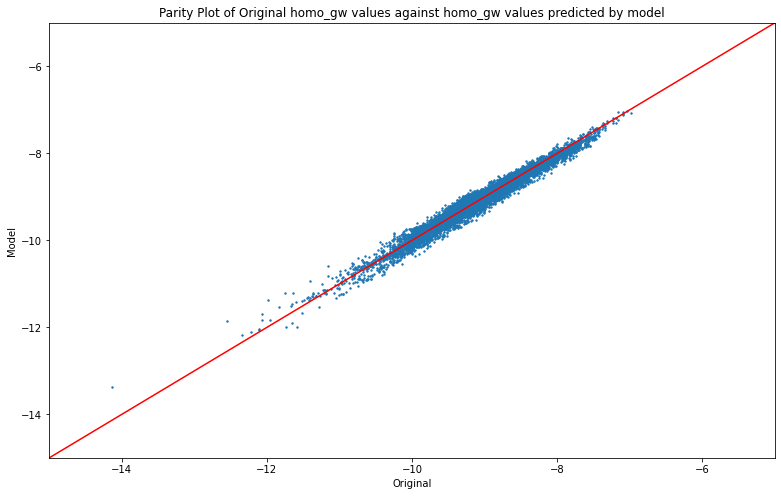

beta_0, beta_i:  -1.47839531165054 [1.08558281]


In [65]:
plt.figure(figsize=(13,8))
plt.title('Parity Plot of Original homo_gw values against homo_gw values predicted by model')
plt.xlim(-15,-5)
plt.ylim(-15,-5)
plt.scatter(qm7b['homo_gw'],model1.predict(qm7b[['homo_pbe0']].values), s=2)
plt.xlabel('Original')
plt.ylabel('Model')
#for reference, plot line x=y
plt.plot(np.linspace(-15,-5,10),np.linspace(-15,-5,10), c='r')
plt.show()
print('beta_0, beta_i: ', model1.intercept_, model1.coef_)

And now for `model2`:

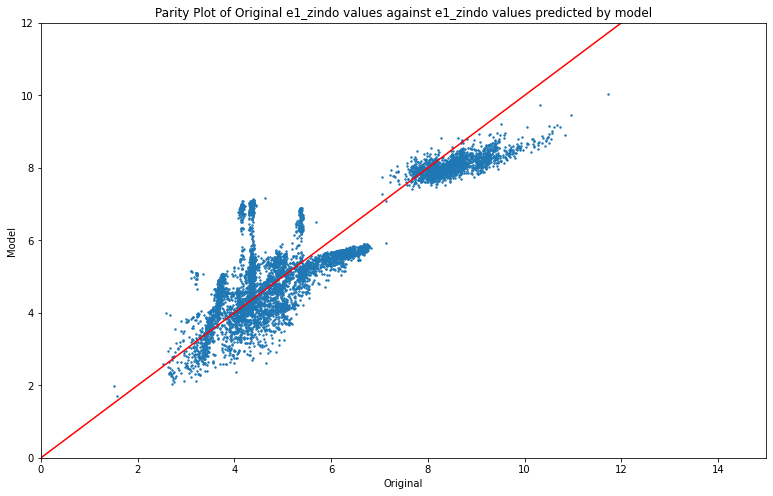

beta_0, beta_i:  0.4695946676895666 [-0.4013178   1.12471506]


In [66]:
plt.figure(figsize=(13,8))
plt.title('Parity Plot of Original e1_zindo values against e1_zindo values predicted by model')
plt.xlim(0,15)
plt.ylim(0,12)
plt.scatter(qm7b['e1_zindo'],model2.predict(qm7b[['homo_zindo','lumo_zindo']]), s=2)
plt.xlabel('Original')
plt.ylabel('Model')
#for reference, plot line x=y
plt.plot(np.linspace(0,14,14),np.linspace(0,14,14), c='r')
plt.show()
print('beta_0, beta_i: ', model2.intercept_, model2.coef_)

As you can see, the correlation between original and predicted/modeled is much less tight for `model2` as compared against `model1`.

#### Exercise 4: Create a Parity Plot for the model for `lumo_pbe0` vs. `lumo_gw` you created in Exercise 1

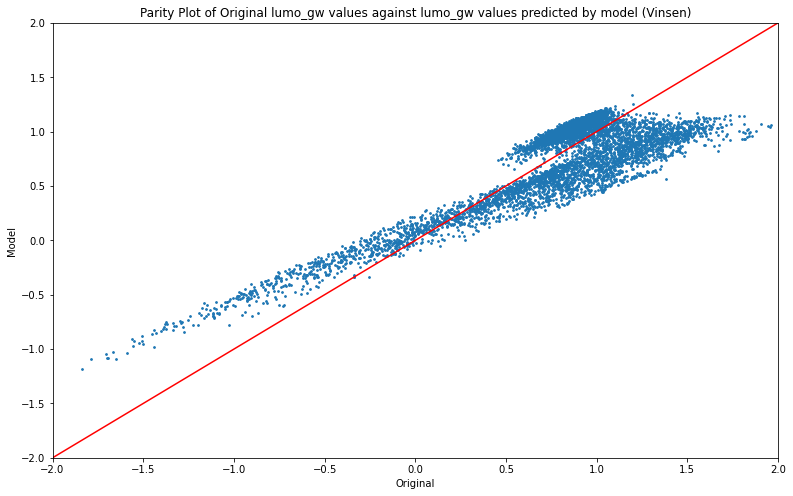

beta_0, beta_i:  1.091422477758899 [0.59745192]


In [77]:
plt.figure(figsize=(13,8))
plt.title('Parity Plot of Original lumo_gw values against lumo_gw values predicted by model (Vinsen)')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.scatter(qm7b['lumo_gw'],model_lumo_pbe0_gw.predict(qm7b[['lumo_pbe0']].values), s=3)
plt.xlabel('Original')
plt.ylabel('Model')
#for reference, plot line x=y
plt.plot(np.linspace(-2,2,10),np.linspace(-2,2,10), c='r')
plt.show()
print('beta_0, beta_i: ', model_lumo_pbe0_gw.intercept_, model_lumo_pbe0_gw.coef_)

### Residual Plots 

These are plots of $(y-f(x_n))$ vs. $x$

For `model1`:

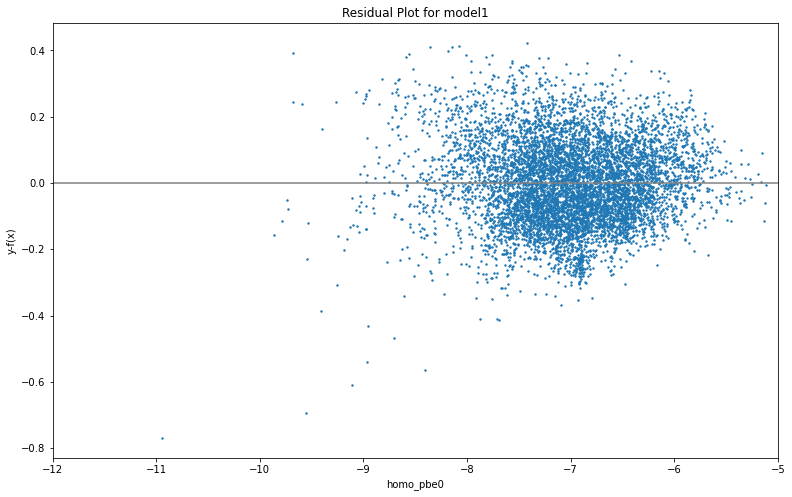

beta_0, beta_i:  -1.47839531165054 [1.08558281]


In [68]:
plt.figure(figsize=(13,8))
plt.title('Residual Plot for model1')
plt.xlim(-12,-5)
#plt.ylim(-15,-5)
plt.scatter(qm7b['homo_pbe0'],qm7b['homo_gw']-model1.predict(qm7b[['homo_pbe0']].values), s=2)
plt.xlabel('homo_pbe0')
plt.ylabel('y-f(x)')
#Plotting a y=0 line for reference
plt.axhline(0, c='grey')
plt.show()
print('beta_0, beta_i: ', model1.intercept_, model1.coef_)

Alternatively, use the `plt.stem` function to show lines from each plot to the $y=0$ line. Recall that this represents the threshold at which $y_n$ = $f(x_n)$

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


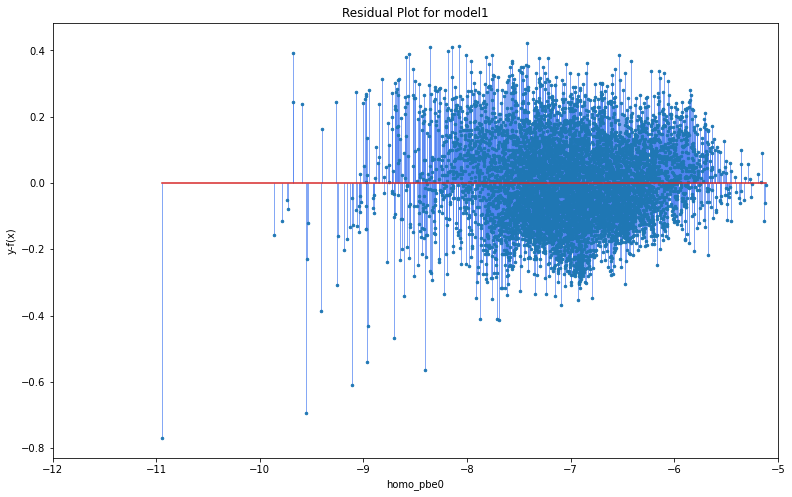

beta_0, beta_i:  -1.47839531165054 [1.08558281]


In [69]:
plt.figure(figsize=(13,8))
plt.title('Residual Plot for model1')
plt.xlabel('homo_pbe0')
plt.ylabel('y-f(x)')
plt.xlim(-12,-5)
#plt.ylim(-15,-5)
#Plotting residuals
markerline, stemline, baseline = plt.stem(qm7b['homo_pbe0'],qm7b['homo_gw']-model1.predict(qm7b[['homo_pbe0']]), use_line_collection=True)
plt.setp(stemline, linewidth = 0.7, color='#5284F2')
plt.setp(markerline, markersize = 2.5)
plt.show()
print('beta_0, beta_i: ', model1.intercept_, model1.coef_)

Now for `model2` residuals:

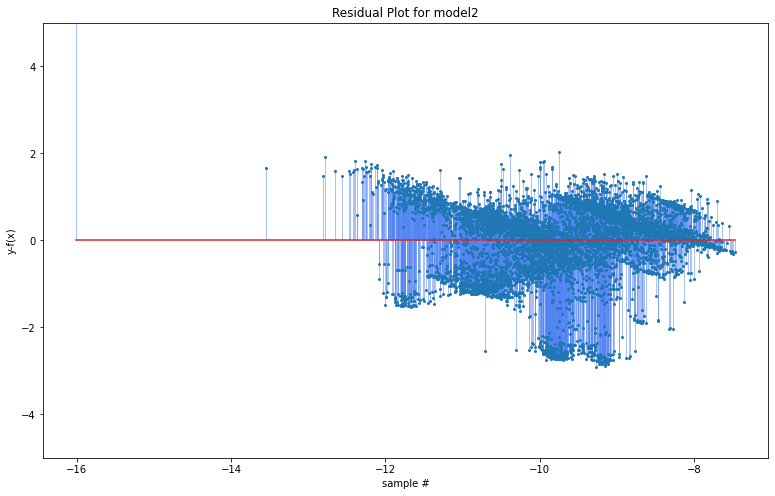

In [70]:
plt.figure(figsize=(13,8))
plt.title('Residual Plot for model2')
plt.xlabel('sample #')
plt.ylabel('y-f(x)')
plt.ylim(-5,5)
#Plotting residuals
markerline, stemline, baseline = plt.stem(qm7b['homo_zindo'],qm7b['e1_zindo']-model2.predict(qm7b[['homo_zindo','lumo_zindo']]), use_line_collection=True)
plt.setp(stemline, linewidth = 0.7, color='#5284F2')
plt.setp(stemline, linewidth = 0.5, color='#5284F2')
plt.setp(markerline, markersize = 2)
plt.show()

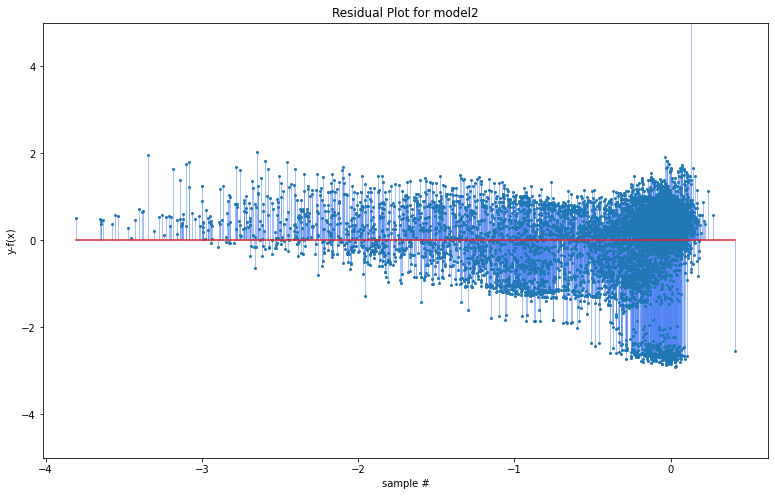

In [71]:
plt.figure(figsize=(13,8))
plt.title('Residual Plot for model2')
plt.xlabel('sample #')
plt.ylabel('y-f(x)')
plt.ylim(-5,5)
#Plotting residuals
markerline, stemline, baseline = plt.stem(qm7b['lumo_pbe0'],qm7b['e1_zindo']-model2.predict(qm7b[['homo_zindo','lumo_zindo']]), use_line_collection=True)
plt.setp(stemline, linewidth = 0.7, color='#5284F2')
plt.setp(stemline, linewidth = 0.5, color='#5284F2')
plt.setp(markerline, markersize = 2)
plt.show()

#### Exercise 5: Create a Residual Plot for the model for  `lumo_pbe0` vs. `lumo_gw` you created in Exercise 1, using `plt.stem` 

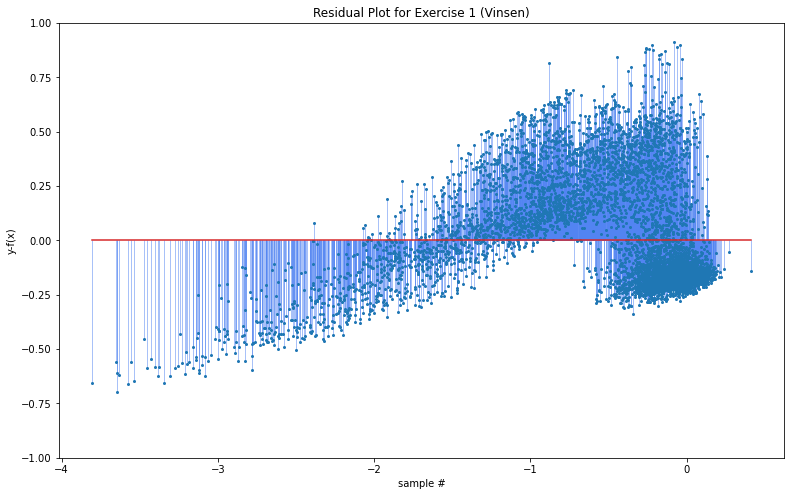

In [79]:
plt.figure(figsize=(13,8))
plt.title('Residual Plot for Exercise 1 (Vinsen)')
plt.xlabel('sample #')
plt.ylabel('y-f(x)')
plt.ylim(-1,1)
#Plotting residuals
markerline, stemline, baseline = plt.stem(qm7b['lumo_pbe0'],qm7b['lumo_gw']-model_lumo_pbe0_gw.predict(qm7b[['lumo_pbe0']].values), use_line_collection=True)
plt.setp(stemline, linewidth = 0.7, color='#5284F2')
plt.setp(stemline, linewidth = 0.5, color='#5284F2')
plt.setp(markerline, markersize = 2)
plt.show()

References:
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error
- https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html
- https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html
- https://jakevdp.github.io/PythonDataScienceHandbook/05.02-introducing-scikit-learn.html
- https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
- https://mathbits.com/MathBits/TISection/Statistics2/correlation.htm